# Time Series Forecasting on NYC_Taxi

w MLFlow

- Objectives
  - Leverage ML FLow to build some time series models

- Simple Forecast of aggregate daily data to start
- Later will need to look at splitting out the datasets into different spots

In [1]:
%load_ext autotime

time: 182 µs (started: 2021-07-27 09:39:29 +00:00)


In [2]:
import os
from pyspark.sql import SparkSession
packages="""io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0"""
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0 pyspark-shell"

time: 105 ms (started: 2021-07-27 09:39:29 +00:00)


In [3]:
from pyspark.sql import functions as F
import pandas as pd

time: 169 ms (started: 2021-07-27 09:39:29 +00:00)


In [4]:
spark = SparkSession \
            .builder \
            .config("spark.executor.cores", 4) \
            .config("spark.executor.memory", "4g") \
            .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
            .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
            .config("spark.master", "spark://spark-master:7077") \
            .config("spark.hadoop.fs.s3a.access.key", os.environ['MINIO_ACCESS_KEY']) \
            .config("spark.hadoop.fs.s3a.secret.key", os.environ['MINIO_SECRET_KEY']) \
            .config("spark.hadoop.fs.s3a.endpoint", "minio:9000") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.metastore.catalog.default", "hive") \
            .config("spark.sql.warehouse.dir", "s3a://storage/warehouse") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.maximum", "50") \
            .config("spark.hive.metastore.uris", "thrift://192.168.64.4:9083") \
            .appName("Jupyter Time Series") \
            .enableHiveSupport() \
            .getOrCreate()

time: 3.07 s (started: 2021-07-27 09:39:29 +00:00)


In [5]:
# tuning settings spark.sql.shuffle.partitions to match with core settings
# not tuned for file size yet

# set to cores to increase the efficiency
spark.conf.set("spark.sql.shuffle.partitions", spark.sparkContext.defaultParallelism*4)

## faster pandas data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

time: 2.55 ms (started: 2021-07-27 09:39:32 +00:00)


In [6]:
from tseries.taxi_daily import TaxiDaily

time: 7.35 ms (started: 2021-07-27 09:39:32 +00:00)


In [7]:
taxi_daily = TaxiDaily(spark)
taxi_daily.load_data()

time: 10.4 s (started: 2021-07-27 09:39:32 +00:00)


In [8]:
taxi_daily.train_data.agg(F.min(F.col('ds')), F.max(F.col('ds'))).collect()

[Row(min(ds)=datetime.date(2013, 8, 1), max(ds)=datetime.date(2014, 6, 30))]

time: 14.7 s (started: 2021-07-27 09:39:42 +00:00)


In [9]:
taxi_daily.test_data.agg(F.min(F.col('ds')), F.max(F.col('ds'))).collect()

[Row(min(ds)=datetime.date(2014, 7, 1), max(ds)=datetime.date(2016, 6, 30))]

time: 14.8 s (started: 2021-07-27 09:39:57 +00:00)


In [10]:
train, test = taxi_daily.train_data.toPandas(), taxi_daily.test_data.toPandas()

time: 29.8 s (started: 2021-07-27 09:40:12 +00:00)


In [11]:
train_sktime = pd.Series(data=train['y'].values, index=pd.to_datetime(train['ds']))
test_sktime = pd.Series(data=test['y'].values, index=pd.to_datetime(test['ds']))

time: 3.47 ms (started: 2021-07-27 09:40:42 +00:00)


# Settings for MLflow

In [12]:
# credentials for storing our model artifacts
# mlflow needs these to be set whenever it is being called
os.environ['AWS_ACCESS_KEY_ID'] = os.environ.get('MINIO_ACCESS_KEY')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.environ.get('MINIO_SECRET_KEY')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://minio:9000'

time: 6.68 ms (started: 2021-07-27 09:40:42 +00:00)


## Forecasting the Dataframe

In [13]:
import prophet
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import mlflow

time: 1.88 s (started: 2021-07-27 09:40:42 +00:00)


There was an error in the hostname resolution hence switch to ip

In [14]:
#mlflow.delete_experiment(1)

time: 150 µs (started: 2021-07-27 09:40:44 +00:00)


In [15]:
mlflow.set_tracking_uri("http://192.168.64.21:5000/")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://192.168.64.21:5000/
time: 4.26 ms (started: 2021-07-27 09:40:44 +00:00)


In [16]:
### Quick test on creating experiments
from mlflow.exceptions import RestException

try:
    mlflow.create_experiment(
        name='taxi_daily_forecast'
    )
except RestException:
    print('already_created')

already_created
time: 567 ms (started: 2021-07-27 09:40:44 +00:00)


In [17]:
experiment = mlflow.get_experiment(15)
experiment.artifact_location

's3://mlflow/15'

time: 22 ms (started: 2021-07-27 09:40:44 +00:00)


In [18]:
# Build an evaluation function
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

time: 273 ms (started: 2021-07-27 09:40:44 +00:00)


In [19]:
# To save models to mlflow we need to write a python wrapper 
# to make sure that it performs as mlflow expects
import mlflow.pyfunc

class ProphetModel(mlflow.pyfunc.PythonModel):
    
    def __init__(self, model):
        
        self.model = model
        super().__init__()
        
    def load_context(self, context):
        from prophet import Prophet
        return
    
    def predict(self, context, model_input):
        future = self.model.make_future_dataframe(periods=model_input['periods'][0])
        return self.model.predict(future)

time: 416 µs (started: 2021-07-27 09:40:44 +00:00)


44 seconds for training by default \
3.62 seconds with processes parallelisation \
13 seconds after we add the toPandas conversion here and run with parallelisation

In [20]:
%time

rolling_window = 0.1

conda_env = {
    'channels': ['conda-forge'],
    'dependencies': [{
        'pip': [
            'prophet=={0}'.format(prophet.__version__)
        ]
    }],
    "name": "prophetenv"
}

with mlflow.start_run(experiment_id=15):
    m = prophet.Prophet(daily_seasonality=True)
    m.fit(taxi_daily.train_data.toPandas())
    
    # cross validation is the thingy that is generating our different train sets
    # tqdm is glitchy with my setup so disabling for now
    df_cv = cross_validation(m, initial="28 days", period="7 days", horizon="14 days", 
                                 disable_tqdm=True, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=rolling_window)
    
    mlflow.log_param("rolling_window", rolling_window)
    mlflow.log_metric("rmse", df_p.loc[0, "rmse"])
    mlflow.log_metric("mae", df_p.loc[0, "mae"])
    mlflow.log_metric("mape", df_p.loc[0, "mape"])
    
    print("  CV: {}".format(df_cv.head()))
    print("  Perf: {}".format(df_p.head()))
    
    mlflow.pyfunc.log_model("model", conda_env=conda_env, python_model=ProphetModel(m))
    print(
            "Logged model with URI: runs:/{run_id}/model".format(
                run_id=mlflow.active_run().info.run_id
            )
        )

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 42 forecasts with cutoffs between 2013-09-02 00:00:00 and 2014-06-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4f62180370>
INFO:botocore.credentials:Found credentials in environment variables.


  CV:           ds           yhat     yhat_lower     yhat_upper       y     cutoff
0 2013-09-03  501585.281837  424923.777491  578749.034750  423109 2013-09-02
1 2013-09-04  518817.592943  445435.828377  592156.733678  454753 2013-09-02
2 2013-09-05  504761.734693  428885.840099  576045.106537  468204 2013-09-02
3 2013-09-06  495324.421080  419383.823020  575130.095967  509666 2013-09-02
4 2013-09-07  474445.011476  400836.598185  546882.438572  512373 2013-09-02
  Perf:   horizon           mse          rmse           mae      mape     mdape  \
0  2 days  2.802909e+09  52942.502951  37278.418974  0.086742  0.049990   
1  3 days  3.124219e+09  55894.709955  37167.961699  0.085093  0.047995   
2  4 days  3.170948e+09  56311.167889  37426.567206  0.081971  0.043602   
3  5 days  2.723070e+09  52183.046660  38084.927978  0.074821  0.056177   
4  6 days  1.912054e+09  43727.040544  33739.912505  0.068865  0.045557   

      smape  coverage  
0  0.078420  0.902299  
1  0.077513  0.859606  
2

# Prophet Diagnostics

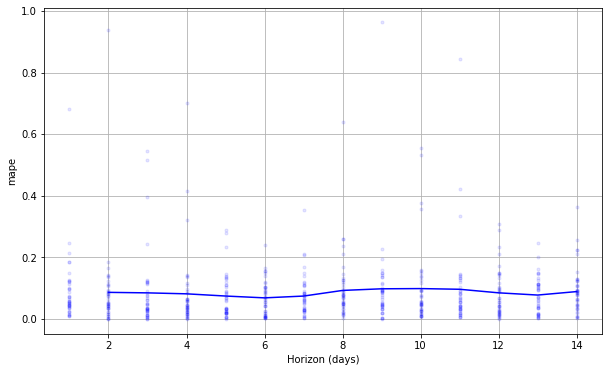

time: 104 ms (started: 2021-07-27 09:41:02 +00:00)


In [21]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

We aren't seeing many differences with longer horizons

In [22]:
future = m.make_future_dataframe(periods=len(taxi_daily.test_data.toPandas()))

time: 15.1 s (started: 2021-07-27 09:41:03 +00:00)


In [23]:
forecast = m.predict(future)

time: 2.77 s (started: 2021-07-27 09:41:18 +00:00)


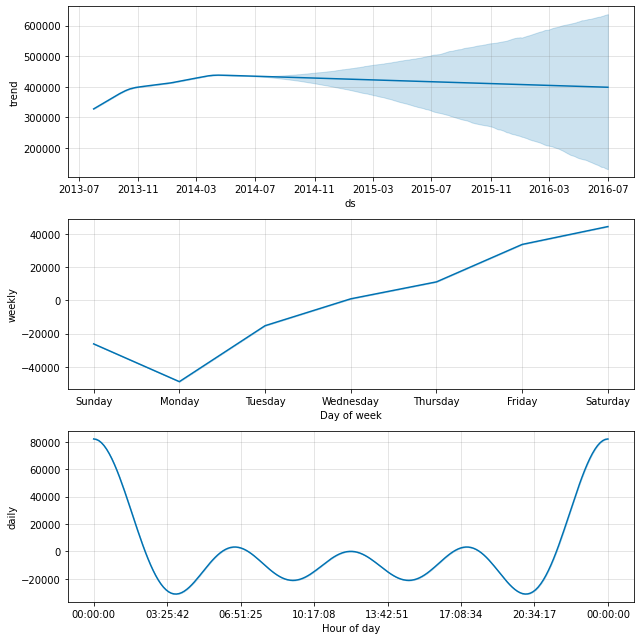

time: 308 ms (started: 2021-07-27 09:41:20 +00:00)


In [24]:
fig = m.plot_components(forecast)

# Testing out Uber Orbit

In [25]:
from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data

time: 580 ms (started: 2021-07-27 09:41:21 +00:00)


In [26]:
dlt = DLTFull(
    response_col='y', date_col='ds',
    #regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=7,
)

time: 362 µs (started: 2021-07-27 09:41:21 +00:00)


In [27]:
dlt.fit(df=taxi_daily.train_data.toPandas())

# outcomes data frame
predicted_df = dlt.predict(df=taxi_daily.test_data.toPandas())

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


time: 31.3 s (started: 2021-07-27 09:41:21 +00:00)


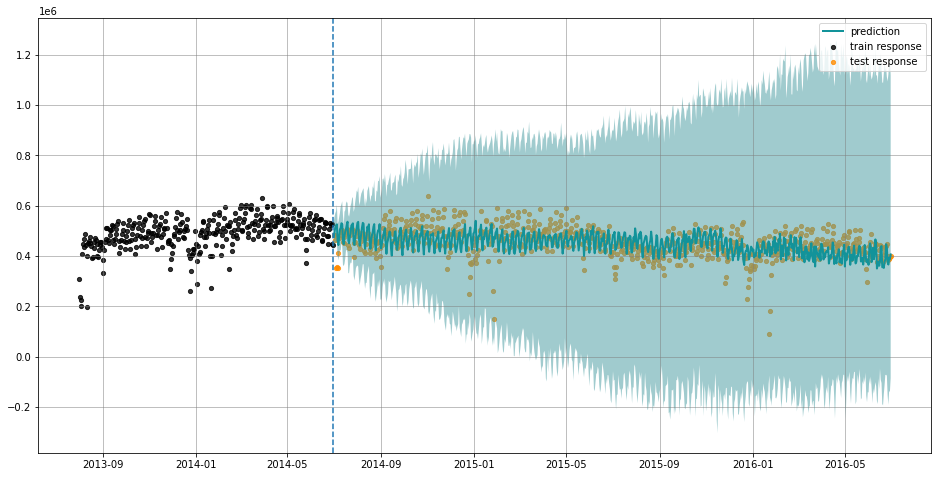

<AxesSubplot:>

time: 28.4 s (started: 2021-07-27 09:41:53 +00:00)


In [28]:
plot_predicted_data(
    training_actual_df=taxi_daily.train_data.toPandas(), predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=taxi_daily.test_data.toPandas()
)

# Testing sktime

In [29]:
from sktime.utils.plotting import plot_series
import numpy as np

time: 110 ms (started: 2021-07-27 09:47:04 +00:00)


In [59]:
print(len(test_sktime))
print(len(train_sktime))

731
334
time: 534 µs (started: 2021-07-28 09:35:16 +00:00)


In [61]:
print("min: {0}, max {1}".format(min(train_sktime.index), max(train_sktime.index)))
print("min: {0}, max {1}".format(min(test_sktime.index), max(test_sktime.index)))


min: 2013-08-01 00:00:00, max 2014-06-30 00:00:00
min: 2014-07-01 00:00:00, max 2016-06-30 00:00:00
time: 3.87 ms (started: 2021-07-28 09:36:23 +00:00)


In [77]:
train_tr = pd.date_range(min(train_sktime.index), max(train_sktime.index))
train_skt_df = pd.Series(train_sktime, index=train_tr)

test_tr = pd.date_range(min(test_sktime.index), max(test_sktime.index))
test_skt_df = pd.Series(test_sktime, index=test_tr)


time: 4.19 ms (started: 2021-07-28 10:58:51 +00:00)


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

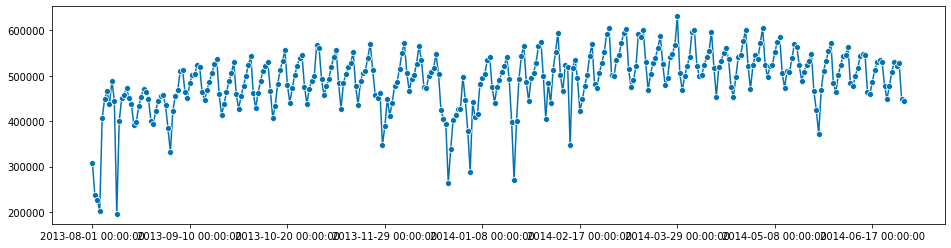

time: 130 ms (started: 2021-07-27 09:47:11 +00:00)


In [31]:
plot_series(train_sktime)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

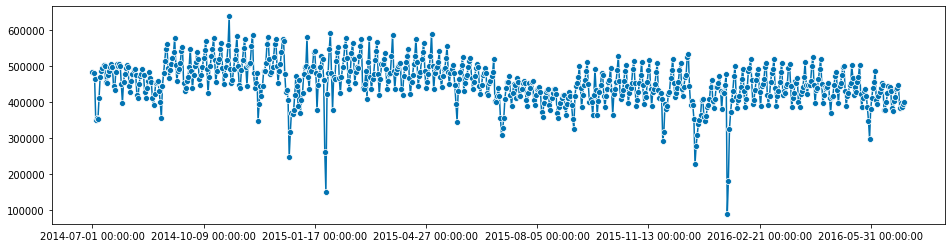

time: 155 ms (started: 2021-07-27 09:47:14 +00:00)


In [32]:
plot_series(test_sktime)

In [33]:
from sktime.forecasting.model_selection import temporal_train_test_split

time: 92 ms (started: 2021-07-27 09:47:16 +00:00)


In [78]:
# test pandas
#pd.PeriodIndex(pd.date_range("2020-01-01", periods=30, freq="D"))
from sktime.forecasting.base import ForecastingHorizon

#fh = ForecastingHorizon(test_sktime.index, is_relative=False)
fh_period = ForecastingHorizon(
    test_skt_df.index, is_relative=False
)

time: 1.58 ms (started: 2021-07-28 10:59:02 +00:00)


In [79]:
from sktime.forecasting.naive import NaiveForecaster

basic_forecaster =  NaiveForecaster(strategy="last")
forecaster = NaiveForecaster(strategy="last")

time: 441 µs (started: 2021-07-28 10:59:04 +00:00)


In [80]:
forecaster.fit(train_skt_df)

NaiveForecaster()

time: 1.56 ms (started: 2021-07-28 10:59:04 +00:00)


In [84]:
# stuck here for now
preds = forecaster.predict(fh_period)

time: 15 ms (started: 2021-07-28 11:13:12 +00:00)


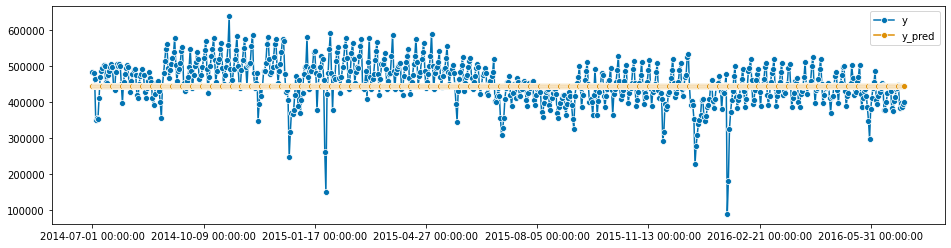

time: 215 ms (started: 2021-07-28 11:13:28 +00:00)


In [86]:
fig, ax = plot_series(test_skt_df, preds, labels=["y", "y_pred"])

In [87]:
from sktime.forecasting.theta import ThetaForecaster

time: 23.9 ms (started: 2021-07-28 11:13:53 +00:00)


In [88]:
# theta forecasting
th_forecaster = ThetaForecaster(sp=12)
th_forecaster.fit(train_skt_df)

alpha = 0.05
y_pred, y_pred_ints = th_forecaster.predict(fh, return_pred_int=True, alpha=alpha)

time: 25.7 ms (started: 2021-07-28 11:14:38 +00:00)


/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


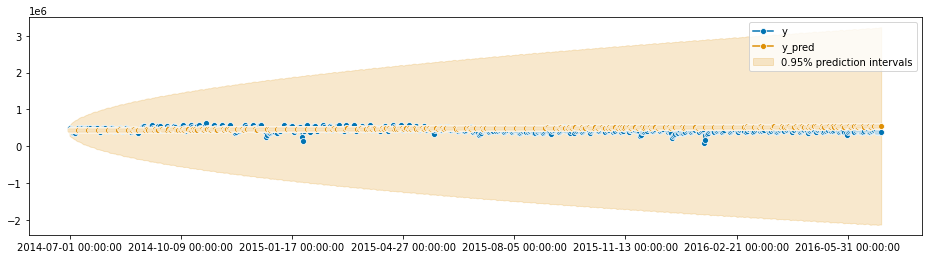

time: 239 ms (started: 2021-07-28 11:14:59 +00:00)


In [90]:
fig, ax = plot_series(test_skt_df, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["lower"],
    y_pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

# Cesium Testing

### generate features

In [114]:
datetimes = [x.strftime('%Y-%m-%d') for x in train["ds"].to_numpy()]

time: 1.51 ms (started: 2021-07-26 14:55:49 +00:00)


In [116]:
from cesium import featurize

features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

fset_cesium = featurize.featurize_time_series(times=datetimes,
                                              values=train["y"].to_numpy(),
                                              errors=None,
                                              features_to_use=features_to_use)
print(fset_cesium.head())


KeyboardInterrupt: 

time: 40min 29s (started: 2021-07-26 14:56:32 +00:00)


# Statsmodels

In [117]:
import statsmodels.api as sm

time: 177 ms (started: 2021-07-26 15:37:06 +00:00)


In [122]:
mod = sm.tsa.SARIMAX(train['y'], order=(1, 0, 0), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  334
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4064.632
Date:                Mon, 26 Jul 2021   AIC                           8135.264
Time:                        15:37:37   BIC                           8146.697
Sample:                             0   HQIC                          8139.822
                                - 334                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.545e+05   1.21e+04     12.788      0.000    1.31e+05    1.78e+05
ar.L1          0.6846      0.026     26.425      0.000       0.634       0.735
sigma2      2.125e+09      0.184   1.16e+10      0.0

## Stopping Spark Session

In [27]:
spark.stop()

time: 442 ms (started: 2021-07-26 11:30:18 +00:00)
